In [1]:
import os
from tqdm import tqdm
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

## Model Implementation

In [2]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

load_pretrained: grid-size from 14 to 16


## Loaders

#### Unsupervised Loader

In [3]:
channel_means = [0.485, 0.456, 0.406]
channel_stds  = [0.229, 0.224, 0.225]
class MyDataset_UnSupervised(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.files = os.listdir(self.image_paths)

    def transform(self, image):  
        # Resize
        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
             
        # Transform to tensor
        image = TF.to_tensor(image) 
        
        #Normalise
        image = TF.normalize(image, channel_means, channel_stds)
        return image
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        img_name = self.files[idx]
        image = Image.open(os.path.join(self.image_paths,img_name))
        image = self.transform(image)
        return image, img_name

In [4]:
DIR_IMG  = os.path.join("./unlabelled/"
                        , 'images')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_Unsupervised = MyDataset_UnSupervised(DIR_IMG)

#Batch Size and Loaders
batch_size_unsupervised = 1
unsupervised_loader = DataLoader(dataset_Unsupervised, batch_size_unsupervised, shuffle = True, 
                          pin_memory=torch.cuda.is_available())#torch.cuda.is_available())
print(len(dataset_Unsupervised)/batch_size_unsupervised)

2893.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


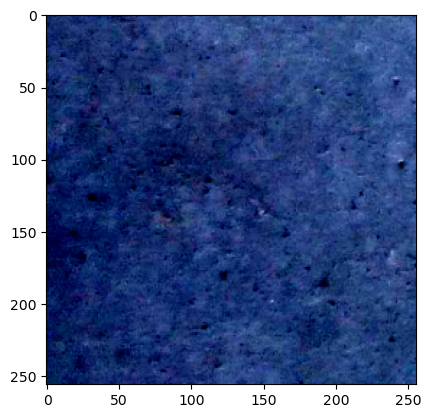

Input ['Ozgenel_O418.jpg']


In [5]:
import matplotlib.pyplot as plt
for i, (image, img_name) in enumerate(unsupervised_loader):
    plt.imshow(image[0].permute(1, 2, 0))
    plt.show()
    print("Input", img_name)
    break

In [6]:
model.load_state_dict(torch.load("Semisup.pth")) # should be changed based on the step number
model = model.cuda()

In [7]:
Confidence_Scores = []
model.eval()
for i, (image1, image_name) in tqdm(enumerate(unsupervised_loader)):
        masks_su = model(image1.cuda())
        masks_su = torch.sigmoid(masks_su)
        
        a = masks_su[0].detach().cpu().numpy()
        
        CS = len(a[(a > 0.1) & (a < 0.9)])
        Confidence_Scores.append(len(a[(a > 0.1) & (a < 0.9)]))
        
        ## Score + image name
        #plt.imsave("./" + 
        #           str(CS) + "__"+ image_name[0][:-3] +"jpg", a[0]*255)
        
        ## Image name + Score
        #plt.imsave("./" + 
        #           str(CS) + "__" +  image_name[0][:-4] + ".jpg", a[0]*255)
            
        #plt.imsave("./
        #Online Self Supervision/01_09Count/" + image_name[0][:-3] +"jpg", a[0]*255)

2893it [01:01, 47.36it/s]


#### TR

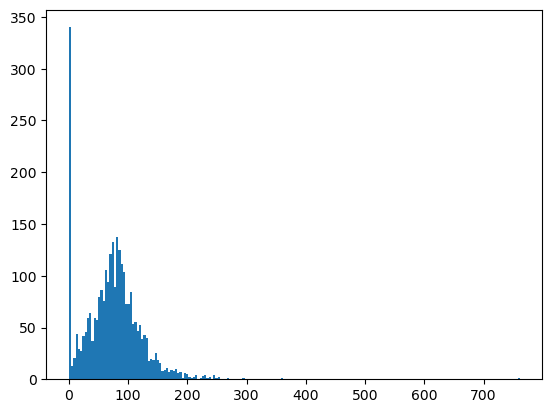

In [8]:
plt.hist(Confidence_Scores, bins=200);

In [9]:
print("Mean", np.mean(Confidence_Scores))
print("STD", np.std(Confidence_Scores))
print("Sum", np.mean(Confidence_Scores) + 3 * np.std(Confidence_Scores))
print("minus", np.mean(Confidence_Scores) - np.std(Confidence_Scores))

a = np.array(Confidence_Scores)
print(len(a[a <= np.mean(Confidence_Scores) + 3 * np.std(Confidence_Scores)]))

Mean 72.8624265468372
STD 48.14918502513554
Sum 217.3099816222438
minus 24.71324152170166


#### SR

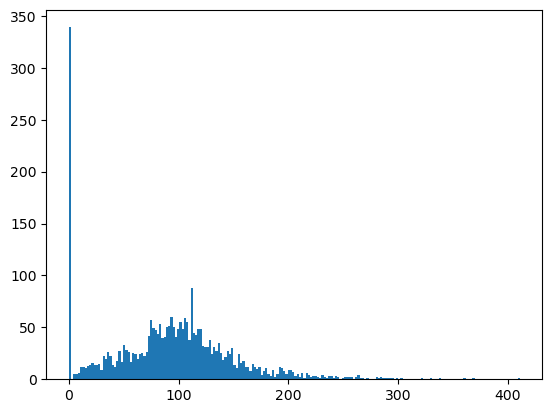

In [8]:
plt.hist(Confidence_Scores, bins=200);

In [10]:
print("Mean", np.mean(Confidence_Scores))
print("STD", np.std(Confidence_Scores))
print("Sum", np.mean(Confidence_Scores) + 2 * np.std(Confidence_Scores))
print("minus", np.mean(Confidence_Scores) - np.std(Confidence_Scores))

a = np.array(Confidence_Scores)
print(len(a[a <= np.mean(Confidence_Scores) + 2 * np.std(Confidence_Scores)]))

Mean 91.94054614586933
STD 57.916646823159034
Sum 207.7738397921874
minus 34.0238993227103


#### FR

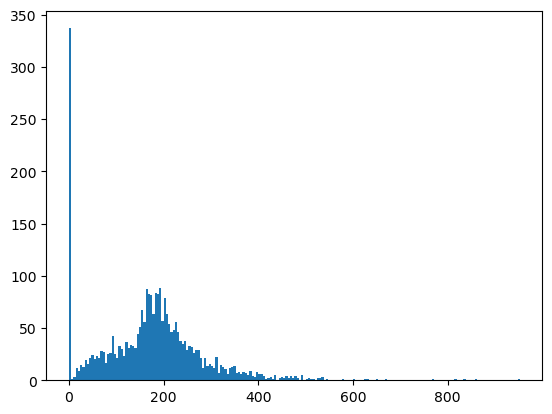

In [10]:
plt.hist(Confidence_Scores, bins=200);

In [11]:
print("Mean", np.mean(Confidence_Scores))
print("STD", np.std(Confidence_Scores))
print("Sum", np.mean(Confidence_Scores) + np.std(Confidence_Scores))
print("minus", np.mean(Confidence_Scores) - np.std(Confidence_Scores))

a = np.array(Confidence_Scores)
print(len(a[a <= np.mean(Confidence_Scores) + 1 * np.std(Confidence_Scores)]))

Mean 171.48496370549603
STD 109.94118182975284
Sum 281.42614553524885
minus 61.54378187574319


#### Label Creation

In [14]:
D = "./Data_FR/RGB_mean+STD/"

Confidence_Scores = []
model.eval()

for i, (image1, image_name) in tqdm(enumerate(unsupervised_loader)):
        masks_su = model(image1.cuda())
        masks_su = torch.sigmoid(masks_su)
        a = masks_su[0].detach().cpu().numpy()
        CS = len(a[(a > 0.1) & (a < 0.9)])
        Confidence_Scores.append(len(a[(a > 0.1) & (a < 0.9)]))
        
        # this changes based on the step number at stage 3
        if CS < np.mean(Confidence_Scores) + np.std(Confidence_Scores): 
            plt.imsave(D + image_name[0][:-4] + ".jpg", a[0]*255) 

./Data_SR/RGB_mean+STD/


2893it [01:05, 44.50it/s]


In [15]:
from PIL import Image
import numpy as np
import os
import cv2

D1= "./Data_FR/RGB_mean+STD/"
D2 = "./Data_FR/masks/"

for i in os.listdir(D1):
    # Make image with small random numbers
    data = Image.open(D1 + i)
    
    im = np.array(data)[:,:,0]
    im[im<127.5] = 0
    im[im>127.5] = 1

    # Make a palette
    palette = [0,0,0,
               255,255,255]  

    # Pad with zeroes to 768 values, i.e. 256 RGB colours
    palette = palette + [0]*(768-len(palette))

    # Convert Numpy array to palette image
    pi = Image.fromarray(im,'P')

    # Put the palette in
    pi.putpalette(palette)

    # Display and save
    #pi.show()
    pi.save(D2 + i[:-3] + "png")

In [16]:
Direc1 = "./Data_FR/masks/"
Direc2 = "./Data_FR/images/"
Direc3 = "./unlabelled/images/"

for i in os.listdir(Direc1):
    shutil.copy(Direc3 + i[:-3] + "jpg",
               Direc2 + i[:-3] + "jpg")